# Setup

## Basic imports and constants

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import skimage

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

from openimages2019 import setup as st
from openimages2019 import utils as u

from skimage.draw import rectangle

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

DATA_DIR = os.path.join(ROOT_DIR, "../data")

#Make GPUs visible
!export HIP_VISIBLE_DEVICES=0,1,2,3


def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax




Using TensorFlow backend.


## Partition the classes according to frequency

We assume that an identical partitioning scheme was implemented when training the models

In [2]:
conn = st._get_sql_conn()

all_classes = st.load_classes(conn)
bboxes = pd.read_sql("SELECT ImageID, XMax, XMin, YMin, YMax, LabelName FROM [Sandbox].[kaggle].[Combined_Set_Detection_BBox]", conn)

tmp = bboxes['LabelName'].value_counts()
tmp = tmp.apply(np.log10)
tmp = tmp.apply(int)

class_sets = []

for i in range(1,7):
    idxs = tmp[tmp == i].index.values
    tmp_set = all_classes[all_classes['LabelName'].isin(idxs)]
    tmp_set = tmp_set.reset_index()
    tmp_set['LabelID'] = tmp_set.index + 1
    class_sets.append(tmp_set)

## Core Functions

In [3]:
class TrainConfig(Config):
    
    NAME = "kaggle"
    GPU_COUNT = 2
    IMAGES_PER_GPU = 2
    IMAGE_MIN_DIM = 512
    IMAGE_MAX_DIM = 512
    STEPS_PER_EPOCH = 500
    
    
def get_infer_model(config, model_path=None):
    inf_model = modellib.MaskRCNN(mode="inference", config=config, model_dir=MODEL_DIR)

    if model_path is None:
        model_path = inf_model.find_last()
        
    inf_model.load_weights(model_path, by_name=True)
    
    return inf_model


def load_member_models(model_paths, class_sets, images_per_gpu=2):
    models = []

    for i,mpath in enumerate(model_paths):

        class KaggleConfig(TrainConfig):
            NUM_CLASSES = len(class_sets[i])+ 1 # + 1 for background class

        class InferenceConfig(KaggleConfig):
            GPU_COUNT = 1
            IMAGES_PER_GPU = images_per_gpu 

        inf_config = InferenceConfig()

        model = get_infer_model(inf_config,model_path=os.path.join(MODEL_DIR, mpath))
        
        models.append(model)
        
    return models


def assemble(ind_results, iou_threshold=0.3):
    """ Combines the results from many different models across a single images.  Uses NMS to handle overlaps"""

    classes = np.concatenate([x['class_ids'] for x in ind_results])
    scores = np.concatenate([x['scores'] for x in ind_results])

    rois = np.concatenate([x['rois'] for x in ind_results],axis = 0)

    #TODO just to display stuff ... not needed here
    masks = np.concatenate([x['masks'] for x in ind_results],axis = 2)

    to_keep = utils.non_max_suppression(rois, scores, iou_threshold)

    return {'class_ids' : classes[to_keep], 'rois' : rois[to_keep],
            'scores' : scores[to_keep], 'masks' : masks[:,:,to_keep]}


def ensemble_detect(models, images, batch_size, id_offsets, *argv):
    """
    
    For each model, run inference on image batches.  Then groups inference results by image and 
    applys non maximum suppression (via assemble method) to each group.
    
    """
    all_results = [[] for x in images]

    for midx,model in enumerate(models):

        results = []
        
        # Have to do this because of model.detect batch size assertion
        for j in range(0,len(images),batch_size):
            results += model.detect(images[j:j+batch_size], verbose=0)

        for i in range(len(results)):
            r = results[i]

            r['model_id'] = midx
            r['class_ids'] += id_offsets[midx]

            all_results[i].append(r)
            
    return [assemble(x) for x in all_results]
    

# Inference

## Member model label ids --> ensemble model label ids

In [4]:
background = ['/mnull','Background']
    
z = [np.insert(cset[['LabelName','LabelDescription']].values,0,background,axis=0) for cset in class_sets]

omni_class_set = pd.DataFrame(np.concatenate(z),columns=['LabelName','LabelDescription'])

id_offsets = omni_class_set[omni_class_set['LabelName'] == '/mnull'].index.values

## Load models

In [5]:
model_paths = ['kaggle20190815T2120/mask_rcnn_kaggle_0025.h5','kaggle20190815T2229/mask_rcnn_kaggle_0025.h5',
               'kaggle20190815T2347/mask_rcnn_kaggle_0025.h5','kaggle20190816T0115/mask_rcnn_kaggle_0025.h5',
               'kaggle20190816T0256/mask_rcnn_kaggle_0025.h5','kaggle20190816T0441/mask_rcnn_kaggle_0100.h5']


models = load_member_models(model_paths, class_sets)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Re-starting from epoch 25
Re-starting from epoch 25
Re-starting from epoch 25
Re-starting from epoch 25
Re-starting from epoch 25
Re-starting from epoch 100


## Run detection

In [6]:
img = skimage.io.imread(os.path.join(DATA_DIR, 'train/2fef4dd2f83feb18.jpg'))
img2 = skimage.io.imread(os.path.join(DATA_DIR, 'train/55dee1384cd565ee.jpg'))

images = [img,img2]

detected = ensemble_detect(models, images,2, id_offsets)

## Visualize

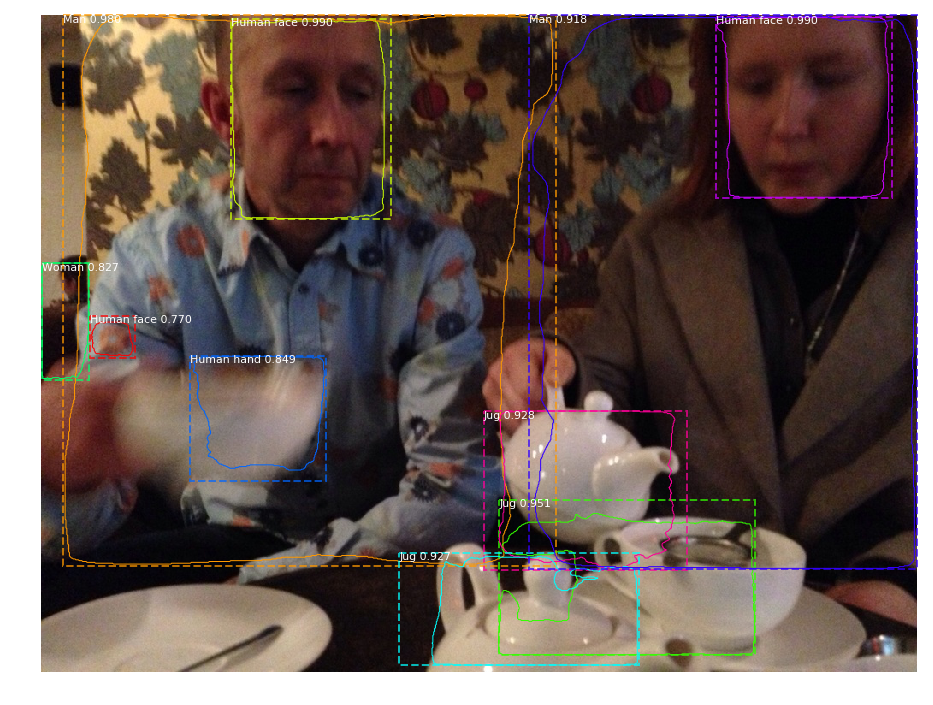

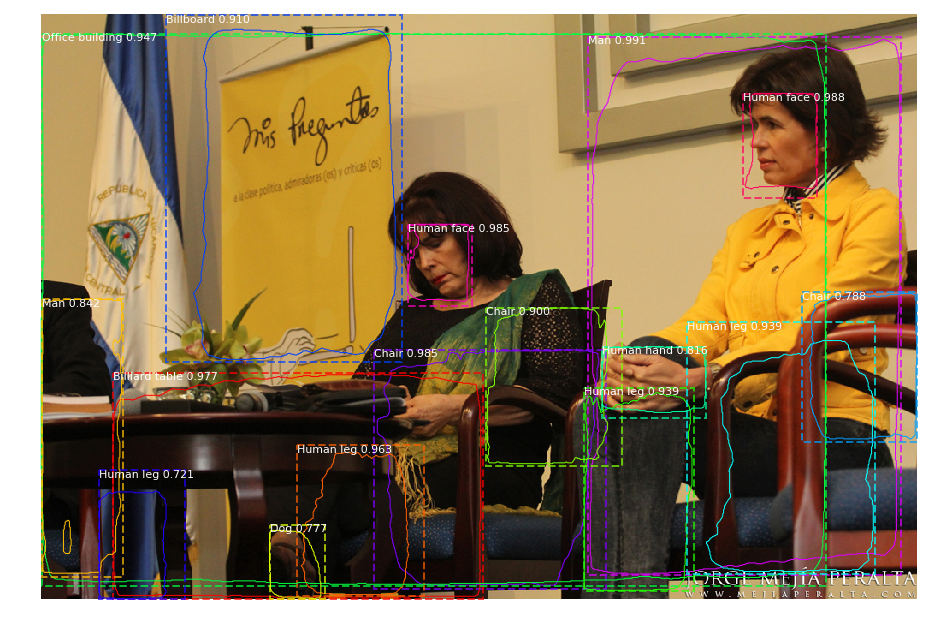

In [7]:
for i,r in enumerate(detected):
    visualize.display_instances(images[i], r['rois'], r['masks'], r['class_ids'], omni_class_set['LabelDescription'].values, r['scores'], show_mask=False)

## Evaluate

### Build the validation data set

In [9]:
tmp_set_classes = omni_class_set.copy()

tmp_set_classes['LabelID'] = tmp_set_classes.index

tmp_set_classes.head()


,LabelName,LabelDescription,LabelID
0,/mnull,Background,0
1,/m/01kb5b,Flashlight,1
2,/m/01k6s3,Toaster,2
3,/m/07dd4,Torch,3
4,/m/04zwwv,Ring binder,4


In [10]:
anns = st.load_annotations_by_image()

In [11]:
anns.head()

,ImageID,RelativePath,Height,Width,Mode,XMax,XMin,YMin,YMax,LabelName,LabelDescription,LabelID
0,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.697656,0.089844,0.000000,0.936458,/m/04yx4,Man,114
1,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.388281,0.221875,0.000000,0.309375,/m/0dzct,Human face,280
2,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.960156,0.778906,0.000000,0.300000,/m/0dzct,Human face,280
3,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.332812,0.000000,0.864583,0.998958,/m/050gv4,Plate,473
4,2fef4dd2f83feb18,train/2fef4dd2f83feb18.jpg,768,1024,RGB,0.946875,0.605469,0.836458,0.998958,/m/050gv4,Plate,473


In [ ]:
#TODO 

train_paths = anns_by_image[anns_by_image['RelativePath'].str.contains('validation',regex=False)]
train_grouped = train_paths.groupby('ImageID')

# Training dataset
dataset = FullKaggleImageDataset()
dataset.add_classes(classes)
dataset.load_kaggle_images(data_dir, train_grouped)
dataset.prepare()

### Calculate mAP

In [ ]:
# model, dataset, config, sample_size=50

image_ids = np.random.choice(dataset.image_ids, sample_size)

#each input is a tuple of form : image, image_meta, gt_class_id, gt_bbox, gt_mask
inputs = [modellib.load_image_gt(dataset, config, iid, use_mini_mask=False) for iid in image_ids]

APs = []

results = ensemble_detect(models, [inp[0] for inp in inputs],2, id_offsets)

for j in range(len(results)):
    r = results[j]
    # Compute AP
    AP, precisions, recalls, overlaps = utils.compute_ap(inputs[j][3], inputs[j][2], inputs[j][4], 
                                        r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
        
np.mean(APs)


# for i in range(0,len(image_ids),n): 

#     curr_inputs = inputs[i:i+n]

#     results = ensemble_detect(models, images,2, id_offsets)
    
# #     model.detect([inp[0] for inp in curr_inputs], verbose=0)

#     for j in range(len(results)):
#         r = results[j]
#         # Compute AP
#         AP, precisions, recalls, overlaps = utils.compute_ap(curr_inputs[j][3], curr_inputs[j][2], curr_inputs[j][4], 
#                                             r["rois"], r["class_ids"], r["scores"], r['masks'])
#         APs.append(AP)
        
# np.mean(APs)




# Misc

## Visualize results for individual models

In [ ]:
import skimage

# test on a few random images
# image_ids = np.random.choice(dataset_val.image_ids, inference_config.BATCH_SIZE)

# images = [skimage.io.imread(os.path.join(DATA_DIR, rel_path)) for rel_path in ]

#TODO should store image id in result as well ... this is just a quick hack

img = skimage.io.imread(os.path.join(DATA_DIR, 'train/2fef4dd2f83feb18.jpg'))
img2 = skimage.io.imread(os.path.join(DATA_DIR, 'train/55dee1384cd565ee.jpg'))

images = [img,img2]

#To store each models result for each image
all_results = [[] for x in images]

model_paths = ['kaggle20190815T2120/mask_rcnn_kaggle_0025.h5','kaggle20190815T2229/mask_rcnn_kaggle_0025.h5',
               'kaggle20190815T2347/mask_rcnn_kaggle_0025.h5','kaggle20190816T0115/mask_rcnn_kaggle_0025.h5',
               'kaggle20190816T0256/mask_rcnn_kaggle_0025.h5','kaggle20190816T0441/mask_rcnn_kaggle_0100.h5']


models = load_member_models(model_paths, class_sets)


for midx,model in enumerate(models):

    results = model.detect(images, verbose=0)
    
    for i in range(len(results)):
        r = results[i]
        
        r['model_id'] = midx
        r['class_ids'] += id_offsets[midx]
        
        all_results[i].append(r)
        
        visualize.display_instances(images[i], r['rois'], r['masks'], r['class_ids'], omni_class_set['LabelDescription'].values, r['scores'])